# Detecting Power Outages with Tweets
### Sang Cheon, Ethan Henley, and Jason Morman
### Notebook 03: Modeling and Conclusion

## Notebook 03 Contents:
- [Loading](#Loading)
- [Preprocessing](#Preprocessing)
- [Word2Vec](#Word2Vec)
- [Decision Tree Classifier](#Decision-Tree-Classifier)
    - [Establish Features and Target](#Establish-Features-and-Target)
    - [Model](#Model)
    - [Model Evaluation](#Model-Evaluation)
- [Classifying Uncertain Data](#Classifying-Uncertain-Data)
- [Conclusion](#Conclusion)
- [Appendicies](#Appendicies)

## Loading

Imports.

In [1]:
import numpy as np

import pandas as pd

import re
from nltk.corpus import stopwords

import gensim
import gensim.models.word2vec as w2v

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

Load tweet DataFrames.

In [2]:
wa_tweets = pd.read_csv('../data/wa_tweets.csv')
outages = pd.read_csv('../data/washington_outages.csv')

Slight bit of extra cleaning; should work sequentially, so will drop tweets that are in our positive class from our unknown class, as well as removing duplicates within each class.

In [3]:
wa_tweets.drop_duplicates(subset='text', inplace=True)

## Preprocessing
These steps are adapted from the work of Noah Christiansen, Jen Hill, and Vonn Napoleon Johnson, available [here](https://github.com/jenrhill/Power_Outage_Identification).

Generate a stopword list, but remove typical stopwords that might be outage-related.

In [4]:
# set up stopwords, but include certain relevant but common words

stops = [w for w in stopwords.words('english') 
         if w not in ['out','on','off']] + ['']

Clean tweets:
- Read #s/hashtags as simple words.
- Dehyphenate.
- Remove @'s/handles and most urls.
- Remove all non-letters.
- Lowercase.
- Tokenize.
- Remove stopwords.

In [5]:
# this function adapted from christiansen et al's
# tweets_to_tweetlist
# cleans, reformats, tokenizes, and removes stopwords from tweets

def tweets_cleaner(raw):
    
    clean = str(raw).replace('-',' ').replace('#',' ')
    clean = re.sub(r"([@][\w_-]+)", "", clean) # remove handles
    clean = re.sub(r"http.*?\b","",clean)
    clean = re.sub(r"pictwitter.*?\b","",clean)
    clean = re.sub(r"www.*?\b","",clean)
    clean = re.sub(r"[^a-zA-Z ]", "", clean)
    clean = clean.lower().split()
    clean = [w for w in clean if w not in stops]
    return clean

List tweets for our positive class, tweets from outage locations during outages that we expect are outage-related..

In [6]:
# clean tweets and compound in list

tweet_list = [tweets_cleaner(t)
              for t in wa_tweets.loc[wa_tweets['outage']==1, 'text']]
#              all tweets expected to be outage-related ^

Inspect the results of cleaning on our positive class.

In [7]:
# visualize tweets against the words they're reduced down to

pd.DataFrame([(a,b) for a,b in zip(list(
    wa_tweets.loc[wa_tweets['outage']==1, 'text']), 
                                   tweet_list)],
             columns=['Tweet','Words'])

,Tweet,Words
0,@Number12ForLife No power in Issaquah Highland...,"[power, issaquah, highlands, understand, issaq..."
1,@KING5Seattle @KIRO7Seattle tiger mountain rd ...,"[tiger, mountain, rd, se, block, way, blocking..."
2,@KING5Seattle @KIRO7Seattle SE may valley road...,"[se, may, valley, road, closed, moment, tree, ..."
3,Just lost power. They power better be back on ...,"[lost, power, power, better, back, on]"
4,Update: Power Outages Affecting Renton's Benso...,"[update, power, outages, affecting, rentons, b..."
...,...,...
179,Power is restored! We’ll be open regular hours...,"[power, restored, well, open, regular, hours, ..."
180,"Soooo, the power is out. @psetalk says they e...","[soooo, power, out, says, expect, us, running,..."
181,Tree hanging across road on power line. @ Bain...,"[tree, hanging, across, road, on, power, line,..."
182,"Power's out, but we're still open! Feel free t...","[powers, out, still, open, feel, free, come, v..."


## Word2Vec

Generate a Word2Vec model based on [Alexandre Salle's](https://github.com/alexandres/lexvec#pre-trained-vectors) LexVec [scrape of Wikipedia](https://www.dropbox.com/s/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz?dl=1). 

We use this pretrained model rather than developing one based on tweets, as our efforts to develop a tweet-trained model led to abysmal word relationships that bore little relation to our goal. Though it does not account for every word we might find on Twitter, the Wikipedia corpus is robust to arbitrary-ness in a way that no Tweet corpus could be.

In [8]:
model = gensim.models.KeyedVectors.load_word2vec_format(
    '../data/lexvec.enwiki+newscrawl.300d.W.pos.vectors')

Confirm the model has a sensible understanding of an outage term.

In [9]:
model.most_similar('blackout')

[('outage', 0.6274550557136536),
 ('blackouts', 0.6006176471710205),
 ('outages', 0.484832227230072),
 ('shutdown', 0.4596997797489166),
 ('curfew', 0.41762691736221313),
 ('lockdown', 0.41292476654052734),
 ('blacked', 0.4122679829597473),
 ('shutdowns', 0.41034194827079773),
 ('cancellation', 0.40724366903305054),
 ('glitch', 0.3966738283634186)]

This next cell of code was originally written by Boom Devahastin Na Ayudhya and was edited by Christiansen et al. for a similar project. It is taken verbatim and can be found [here](https://github.com/jenrhill/Power_Outage_Identification/blob/master/code/2_Preprocessing_and_Word2Vec_Model.ipynb) in the repo linked previously. It is a function that effectively generates an average W2V vector for a series of words.

In [10]:
# code from Boom Devahastin Na Ayudhya edited by Christiansen et al
def vectorize_corpus(keyword_list,model=model):    
    
    # Instantiate counter for number of words in keyword_list that exists
    n_words = 0
    
    # Create template for cumulative corpus vector sum
    corpus_vec_sum = np.zeros((1,300))                 
    
    # Scan through each word in list
    for word in keyword_list:
        if word in model.vocab:                    
            word_vec = model.word_vec(word)        
            n_words +=1                                
            corpus_vec_sum = corpus_vec_sum + word_vec 

    # Compute average vector by taking cumulative vector sum 
    # and dividing it by number of words traced
    corpus_avg_vec = corpus_vec_sum/n_words
    
    # Squeeze this N-dimensional nested array object into a 
    # 1-D array to streamline future processing
    corpus_avg_vec = np.squeeze(corpus_avg_vec)
    
    return(corpus_avg_vec)

A series of cosine similarity functions for comparing vectors, words, words with corpus vectors, and cleaned tweets with corpus vectors.

In [11]:
def cos_sim(v1, v2): 
    return np.dot(v1,v2)/np.sqrt(np.dot(v1,v1)*np.dot(v2,v2))

def cos_sim_words(w1,w2,model=model):
    try:
        return cos_sim(model.word_vec(w1),model.word_vec(w2))
    except:
        print(f'{w1} or {w2} not in vocabulary.')
        return np.nan
    
def cos_sim_wc(word,corpus_vector,model=model):
    try:
        return cos_sim(model.word_vec(word),corpus_vector)
    except:
        print(f'\t{word} not in vocabulary.')
        return np.nan
    
def cos_sim_tc(tweet, corpus_vector, model=model):
    tweet_vector = vectorize_corpus(tweet)
    return cos_sim(tweet_vector, corpus_vector)

A small corpus of single words believed to be related to power outages. We deliberately exclude the words used in our Twitter query (blackout, outage, and power) from this list of words, as at least one of them should be present in every single member of our positive class.

In [12]:
power_out = ['brownout','line','transformer', 'electricity', 'shutdown',
             'storm','pseg','damage','powerout','backup','cable',
             'cutoff','overload','fire','grid','energy',
             'surge','lights','light','cut','failure',
             'severe','substation','lines','voltage','short','disruption']

power_out_vector = vectorize_corpus(power_out)

In [13]:
model.most_similar(power_out)

[('outages', 0.6018792986869812),
 ('outage', 0.5885301828384399),
 ('blackouts', 0.56641685962677),
 ('substations', 0.5494413375854492),
 ('generators', 0.5467642545700073),
 ('grids', 0.5460854768753052),
 ('disruptions', 0.5358939170837402),
 ('leakage', 0.5245850086212158),
 ('inverter', 0.5203883647918701),
 ('cooling', 0.5186830163002014)]

We can apply the model to our tweets and get respondent cosine similarities.

In [14]:
wa_tweets['Cosine Similarity'] = \
    [cos_sim_tc(tweets_cleaner(t), power_out_vector) 
     for t in list(wa_tweets['text'])]
wa_tweets = wa_tweets.fillna(0)
# function returns nulls for tweets devoid of words in wikipedia corpus
# so replace them w/ 0s; they represent 0 measurable similarity

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [15]:
wa_tweets[['text','outage','Cosine Similarity']].head()

,text,outage,Cosine Similarity
0,@Number12ForLife No power in Issaquah Highland...,1,0.300520
1,@KING5Seattle @KIRO7Seattle tiger mountain rd ...,1,0.494567
2,@KING5Seattle @KIRO7Seattle SE may valley road...,1,0.449322
3,Just lost power. They power better be back on ...,1,0.488947
4,Update: Power Outages Affecting Renton's Benso...,1,0.614445


What can we see about the distribution of cosine similarity for our positive and negative classes?

In [16]:
print('Mean')
wa_tweets.groupby('outage').mean().loc[[0,1]]

Mean


,Cosine Similarity
outage,
0,0.200232
1,0.418014


## Decision Tree Classifier

Now that we have an unsupervised model that outputs some metric, we'll use a decision tree stump to create a cutoff point in cos similarity for good tweets and bad.

As a reminder: our positive class, 1, is outage-related tweets; our negative class, 0, is outage-agnostic tweets; the -1 class is uncertain/potential outage tweets. We only use the 1 and 0 classes in the decision tree.

Let's look at the distribution of outage relatedness in our data.

In [17]:
wa_tweets['outage'].value_counts()

 0    4988
-1    2798
 1     184
Name: outage, dtype: int64

A decision tree measuring on accuracy won't work well if the data is so lopsided, so let's create an evenly split DataFrame with bootstrapping.

Format data for modeling—remove values that are neither in the positive nor negative class.

In [18]:
wa_for_m = wa_tweets[wa_tweets['outage'] >= 0]

### Establish Features and Target

Set up features and target.

In [19]:
X = pd.DataFrame([cos_sim_tc(tweets_cleaner(t), power_out_vector)
                  for t in list(wa_for_m['text'])]).fillna(0)
y = wa_for_m['outage'].reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Train test split. We use a large test size to ensure meaningful test statistics, at some cost to the model, and stratify to facilitate the forthcoming bootstrapping.

In [20]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,
# large test size to ensure good test measurements for low n
                                                    test_size = .5, 
                                                    random_state=1007,
                                                    stratify=y)

Bootstrap to account for class imbalance.

In [21]:
# seed randoms
np.random.seed(1007)

# bootstrap training

# num of extra positives to add
inflate_num = y_train.value_counts()[0] -\
    y_train.value_counts()[1]

# add positives to y
y_inflate = y_train.loc[
    np.random.choice(y_train[y_train == 1].index,
                     size=inflate_num)]

# add same positives to X
X_inflate = X_train.loc[y_inflate.index]

X_train = pd.concat([X_inflate, X_train])
y_train = pd.concat([y_inflate, y_train])

# do the same thing for testing so that accuracy is scored on 50-50 data

# num of extra positives to add
inflate_num_test = y_test.value_counts()[0] -\
    y_test.value_counts()[1]

# add positives to y
y_inflate_test = y_test.loc[
    np.random.choice(y_test[y_test == 1].index,
                     size=inflate_num_test)]

# add same positives to X
X_inflate_test = X_test.loc[y_inflate_test.index]

X_test = pd.concat([X_inflate_test, X_test])
y_test = pd.concat([y_inflate_test, y_test])

### Model

Run one-deep decision tree to establish cutoff.

In [22]:
# use decision tree stump (ONE LAYER ONLY) to split

dtc = DecisionTreeClassifier(max_depth=1)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

### Model Evaluation

We use accuracy as our primary metric, as our bootstrapping makes this appropriate, and because the decision tree stump does not meaningfully determine probabilities for AUC ROC.

In [23]:
print('Train Accuracy:',dtc.score(X_train,y_train))
print('Test Accuracy: ',dtc.score(X_test,y_test))

Train Accuracy: 0.8899358460304732
Test Accuracy:  0.8879310344827587


Our model is fairly accurate and not overfit. There is bias present, as should be expected for such a weak learner as a single decision tree stump, but since we are working only on the one feature of cosine similarity, this is stlil appropriate.

Confusion matrix:

In [24]:
# confusion matrix

cm = confusion_matrix(y_test, dtc.predict(X_test))
cm
#    pf pt
# af tn fp
# at fn tp

array([[2038,  456],
       [ 103, 2391]], dtype=int64)

In [25]:
tn, fp, fn, tp = cm.flatten()
sens = tp / (tp + fn)
spec = tn / (tn + fp)
print('Sensitivity:',sens)
print('Specificity:',spec)

Sensitivity: 0.958700882117081
Specificity: 0.8171611868484362


These scores aren't bad. They tell us the model is very sensitive, more likely to predict positive than negative on evenly split data. There are very few false negatives, more false positives. This is acceptable, as we'd rather get some more false alarms than miss many real outages.

Approximate the cutoff point just by running in possible values, since decision tree node splits aren't conveniently accessible.

In [26]:
space = np.linspace(0,1,10001)
co_arr = np.array([[i,dtc.predict([[i]])] for i in space])
cutoff = [p for p,a in zip(space,co_arr[:,1]) if a[0]==1][0]
print('Decision Tree Cutoff is cosine similarity of',cutoff)

Decision Tree Cutoff is cosine similarity of 0.2788


Let's see where this falls in the distributions.

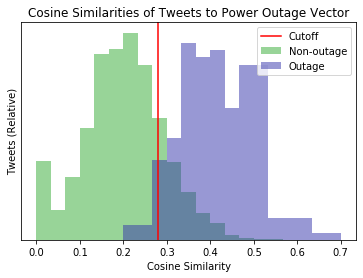

In [27]:
bins = np.linspace(0,.7,22)

# use density=True to de-emphasize proporition differences
plt.hist(X[y == 0][0],bins=bins,density=True,
         color='#33AA33',alpha=.5)
plt.hist(X[y == 1][0],bins=bins,density=True,
         color='#3333AA',alpha=.5)

# cutoff
plt.axvline(x=cutoff,c='r')

plt.legend(['Cutoff','Non-outage','Outage'])
plt.xlabel('Cosine Similarity')
plt.ylabel('Tweets (Relative)')
plt.yticks([])
plt.title('Cosine Similarities of Tweets to Power Outage Vector')
plt.savefig(f'../figures/cutoff.png');

## Classifying Uncertain Data

Let's look at how the model applies to the uncertain data—this is essentially our use case, determining the outage-relatedness of ambiguous tweets.

In [28]:
inspect_df = wa_tweets[wa_tweets['outage']==-1][
    ['event_row_or_county','timestamp','text']].reset_index(drop=True)

inspect_df['words'] = [tweets_cleaner(t) for t in list(inspect_df['text'])]

inspect_tweets = pd.DataFrame(
    [cos_sim_tc(t, power_out_vector)
     for t in inspect_df['words']]).fillna(0)

inspect_df['outage_prediction'] = dtc.predict(inspect_tweets)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [29]:
inspect_df['outage_prediction'].value_counts()

1    2489
0     309
Name: outage_prediction, dtype: int64

This is a lot of positives, but that shouldn't necessarily worry us, as this is set of tweets was constrained in scraping to contain at least one of our outage-related words, and on our testing data we still had a decent specificity.

We can run this model on all our tweets.

In [30]:
wa_tweets['outage_prediction'] = \
    dtc.predict(wa_tweets[['Cosine Similarity']])
wa_tweets.head()

,event_row_or_county,timestamp,text,outage,Cosine Similarity,outage_prediction
0,0,2012-01-19 22:55:20,@Number12ForLife No power in Issaquah Highland...,1,0.300520,1
1,0,2012-01-19 22:26:31,@KING5Seattle @KIRO7Seattle tiger mountain rd ...,1,0.494567,1
2,0,2012-01-19 22:24:36,@KING5Seattle @KIRO7Seattle SE may valley road...,1,0.449322,1
3,0,2012-01-19 21:40:50,Just lost power. They power better be back on ...,1,0.488947,1
4,0,2012-01-19 20:32:02,Update: Power Outages Affecting Renton's Benso...,1,0.614445,1


Save predictions.

In [31]:
wa_tweets.to_csv('../data/wa_tweets_preds.csv', index=False)

## Conclusion

Governments, emergency response agencies, and utilities already have tools at their disposal for recognizing and reacting to power outages, but they are not publically available and cannot always respond immediately or account for individual reporting. Twitter is not a convenient source for most data, but with tweets one can detect far more power outages than are, say, reported by the EIA. Our tool, though it is only a limited proof of concept, is clear evidence that even lightweight interpretation of social media posts can generate meaningful conclusions about power outages, as it is successful at determining the outage-relatedness of tweets from the state of Washington with an accuracy of 89%. Were one to integrate it with the Twitter premium API, the resultant tool would provide more useful and specific power outage location data than some preexisting tools and datasets can. We hope that our model, or its structure and principles, can be furthered to better support the organizations that respond to power outages, and we thank the reader for considering our work.

## Appendicies
- [Mapping](./a01_mapping.ipynb)